Agora além de detectarmos faces, iremos também classificar os rostos de pessoas.

Iremos utilizar um Dataset da George Tech, onde temos 15 imagens por pessoa.

[Download Dataset](https://drive.google.com/file/d/1BTY76SQslUDvZ1eslC41Jre3LHkGGsZ_/view?usp=sharing)

In [1]:
# TODO Identificar os rostos de cada imagem, cortar e salvar em memória (em um array) para o pré processamento.

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import cv2.data

# Classificador pré treinado para classificar rostos frontais
classifier = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Função para detectar rostos, passa a imagem e o número de rostos que deve identificar
def face_detector(image, n_faces = 0, scaleFactor = 1.1, minNeighbors = 5, n_faces_throw_error = True):
    faces = classifier.detectMultiScale(image,
                                scaleFactor=scaleFactor,
                                minNeighbors=minNeighbors)
    
    if len(faces) != n_faces and n_faces > 0 and n_faces_throw_error:
        raise Exception(f'O número de faces detectadas ultrapassa o parâmetro fornecido n_faces [{n_faces}]. Faces detectadas: {len(faces)}')
    elif not n_faces_throw_error and len(faces) != n_faces and n_faces > 0:
        return None
    
    return faces

In [3]:
# Função para adquirir todas as imagens de rostos recortadas
def get_person_images(base_path: str):
    images = []
    labels = []

    # listdir lista todos os subdiretórios no caminho específicado
    for person_dir in os.listdir(base_path):
        # Adquire o caminho do subdiretório atual
        person_path = os.path.join(base_path, person_dir)

        # Verifica se é um diretório
        if (os.path.isdir(person_path)):
            for img_file in os.listdir(person_path):
                img_path = os.path.join(person_path, img_file)

                # Verifica se é um arquivo de imagem
                if img_file.lower().endswith(('.png', 'jpg', 'jpeg')):
                    img = cv2.imread(img_path) # Lê a imagem
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Converte os canais de BGR para RGB

                    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # Converte RGB para escala de cinza
                    coords = face_detector(img_gray, 1,
                                           n_faces_throw_error=False) # Não dará erro caso encontre 0 ou mais de uma face, descartará a imagem
                    
                    if coords is not None and len(coords) > 0:
                        x, y, w, h = coords[0] # Acessa primeiro elemento do array e adquire os valores

                        images.append(img[y: y+h, x: x+w]) # Adiciona a imagem na lista
                        labels.append(person_dir) # Adiciona o nome do subdiretório como um label da imagem

    return images, labels

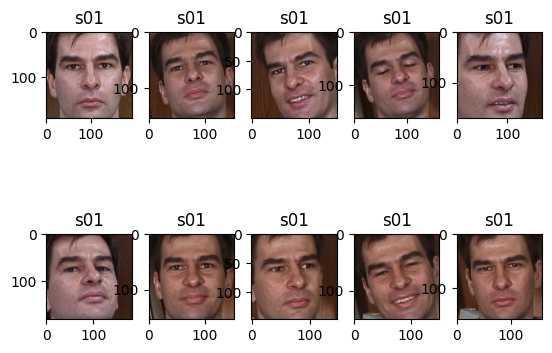

In [4]:
base_path = 'gt_db'

# Adquire as imagens
images, labels = get_person_images(base_path)

# Mostra as 10 primeiras faces
for index in range(0,10):
    plt.subplot(2,5, index+1)

    plt.imshow(images[index])
    plt.title(labels[index])